# Repaso de estadística bayesiana

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

## Contenidos

* [Regla de Bayes](#regla-de-bayes)
* [Modelos bayesianos](#modelos-bayesianos)
* [Problemas](#problemas)
    * [La suerte de Betts](#la-suerte-de-betts)
    * [¿El fútbol siempre da revancha?](#el-fútbol-siempre-da-revancha)
* [Comentarios](#comentarios)

# Regla de Bayes

La regla de de Bayes no es más que una consecuencia directa de la regla del producto:

$$
\begin{aligned}
P(A, B) &= P(A, \mid B) P(B) \\
P(A, B) &= P(B \mid A) P(A)
\end{aligned}
$$

Como ambos términos a la derecha de la igualdad son iguales, podemos escribir:

$$
P(A \mid B) P(B) = P(B \mid A) P(A)
$$

y reordenando llegamos a

$$
P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}
$$

que es la famosa regla de Bayes.

# Modelos bayesianos

Escribir la regla de Bayes de la siguiente manera no dice mucho:

$$
P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}
$$

Además, lo único bayesiano en ella es el nombre.

Hay dos ideas centrales que hacen que un método sea **bayesiano**:

* Toda **cantidad desconocida** es modelada utilizando una **distribución de probabilidad** de algún tipo.
* La regla de Bayes es usada para actualizar dicha distribución a la luz de los datos.

En el universo bayesiano, las cantidades conocidas son consideradas fijas y usualmente les llamamos datos ($y$).

Por el contrario, las cantidades desconocidas se consideran variables aleatorias y conforman el conjunto de parámetros ($\theta$).

Para construir un modelo bayesiano necesitamos:

* Un **modelo para las observaciones**, que nos habla de cómo se pudieron haber generado los datos $p(Y = y\mid \theta)$ (a.k.a. **verosimilitud** o **_likelihood_**).
* Un **modelo, _a priori_,** para los **parámetros** del modelo observacional $p(\theta)$ (a.k.a. **_prior_**).

La combinación de ambos da lugar a lo que se conoce como _full Bayesian model_:

$$
p(y, \theta) = p(y \mid \theta) p(\theta)
$$

que refleja **todos nuestros supuestos** sobre el fenómeno bajo estudio. 

Dado un conjunto de observaciones, se obtiene una distribución _a posteriori_ para los parámetros del modelo:

$$
p(\theta \mid Y = y) 
    = \frac{p(Y = y \mid \theta) p(\theta)}{p(Y = y)}
    =  \frac{\overbrace{p(Y = y\mid \theta)}^{\text{likelihood}} \overbrace{p(\theta)}^{\text{prior}}}{\underbrace{\int_{\Theta} p(Y =y \mid \theta) p(\theta) \text{d}\theta}_{\text{likelihood marginal}}}
$$

El denominador, llamado _likelihood marginal_ o evidencia, es el _likelihood_ promediado sobre todas las posibles hipótesis $\theta$ (i.e. configuraciones posibles del modelo observacional).

El _likelihood marginal_ puede ser visto como una constante de normalización que hace que la densidad _a posteriori_ integre a 1. Por esa razón también se suele ver:

$$
p(\theta \mid Y = y) \propto p(Y = y\mid \theta)p(\theta) = p(Y = y, \theta)
$$

El trabajo de un bayesiano no termina en el hallazo de la distribución _a posteriori_ de $\theta$ expresado como una función de densidad.

A partir de esa función de densidad _a posteriori_ se obtienen cantidades de interés:

* Media
* Varianza
* Percentiles
    * Mediana
    * Intervalos de credibilidad
* Probabilidades

¿Qué tienen en común estas cantidades? Todas se obtienen como valores esperados de la forma:

$$
\mathbb{E}[\varphi(\theta)] = \int \varphi(\theta) p(\theta \mid Y = y) d\theta
$$

Por ejemplo, la media o esperanza _a posteriori_ de $\theta$ es

$$
\mathbb{E}[\theta] = \int \theta p(\theta \mid Y = y) d\theta
$$

## Resumen

Un enfoque bayesiano es aquel que utiliza distribuciones de probabilidad para cuantificar la incertidumbre. 

Se necesita:

1. Asumir un modelo observacional $p(Y = y \mid \theta)$.
2. Asumir un modelo para los parámetros de configuración del modelo observacional $p(\theta)$.
3. Actualizar la distribución sobre los parámetros a la luz de los datos, obteniendo $p(\theta \mid Y = y)$. 
4. Extraer _insights_ de interés en forma de valores esperados obtenidos a partir del _posterior_.

## Una dosis de realidad

Dados nuestros supuestos, lo mejor que podemos hacer para actualizar nuestro conocimiento a partir de los datos es utilizar la regla de Bayes.

Sin embargo, no debemos perder de vista que la fiabilidad de los resultados que obtengamos va a depender de qué tan compatibles son nuestros supuestos iniciales con el "verdadero" proceso generador de datos. Es decir, es necesario evaluar el modelo. Algunas posibilidades son:

* Comparar las predicciones generadas por el modelo con los datos observados
* Evaluar si las conclusiones obtenidas tienen sentido dado el marco conceptual en  que se trabaja
* Determinar si los resultados obtenidos son sensibles a detalles del modelo (sobre todo aquellos detalles para los cuales no tenemos demasiada información)
* ...

Además, es posible que realizar inferencia bayesiana sea demasiado costosa en la práctica por lo que sea conveniente incorporar simplificaciones.

A fin de cuentas, el desarrollo de un modelo bayesiano es casi siempre el resultado de un proceso iterativo donde uno va logrando, paso a paso, un mayor nivel de granularidad en la descripción de un fenómeno, hasta llegar a un nivel que sea "lo suficientemente bueno".

# Problemas

En esta sección vamos a trabajar con dos problemas desde una óptica bayesiana de manera analítica, sin utilizar PyMC. El objetivo es repasar los componentes fundamentales del modelado bayesiano y luego motivar el uso de la simulación computacional para realizar inferencias. En las siguientes _notebooks_, resolveremos estos problemas utilizando PyMC.

## La suerte de Betts

Mookie Betts es un bateador que juega para Los Angeles Dodgers en la Major League Baseball (MLB) de los Estados Unidos.

Este jugador se ha convertido en unas de las estrellas indiscutidas de la competencia al conseguir 45 _hits_ en sus primeros 115 turnos al bate en lo que va de la temporada regular del año 2024.

Según los registros históricos, los bateadores de la MLB consiguen un _hit_ entre el 20% y 40% de las ocasiones que van al bate.

A partir de los datos, ¿qué se puede concluir sobre la probabilidad de que Betts obtenga un _hit_ al batear?

Dado nuestro conocimiento previo y el desempeño de Betts en sus primeros 115 turnos al bate, ¿cuál es la probabilidad de que este jugador obtenga _hits_ en al menos el 40% de los casos al acumular 500 turnos al bate en la temporada?

¿Qué supuesto(s) realizamos? ¿Cuál(es)?

A pensar un poco...

**¿Cuál es un modelo observacional plausible?**

La variable observada es la **cantidad de _hits_** que alcanza el bateador. Es un conteo. Toma valores enteros y su mínimo valor posible es 0 (cuando el jugador no obtiene ningún _hit_). El máximo valor que puede tomar es la cantidad de veces que el jugador va al bate (cuando el jugador obtiene _hit_ en todos los casos).

Es posible pensar que cada turno al bate es un intento o ensayo con dos resultados posibles: éxito (cuando se obtiene un _hit_) y fracaso (cuando no se obtiene un _hit_). Este tipo de ensayo, con dos resultados posibles, se conoce como [ensayo de Bernoulli](https://es.wikipedia.org/wiki/Ensayo_de_Bernoulli). La cantidad observada es la cantidad de éxitos obtenidos.

También se puede suponer que en cada ensayo hay una probabilidad $\theta$ de que el bateador obtenga un _hit_. Si se asume que esta probabilidad de éxito es constante y que los resultados de los ensayos son todos independientes entre sí, la sucesión de ensayos (cada vez que el jugador va al bateo) se conoce como [proceso de Bernoulli](https://es.wikipedia.org/wiki/Proceso_de_Bernoulli). 

Bajo los supuestos mencionados, la cantidad de éxitos obtenidos en una cantidad fija de ensayos sigue una [distribución binomial](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_binomial). En otras palabras, si estamos dispuestos a asumir los supuestos de los párrafos anteriores, surge naturalmente la distribución binomial como modelo observacional para describir la cantidad de _hits_ obtenidos en $N$ intentos.

Escribimos

$$
Y \sim \text{Binomial}(N, \theta)
$$

donde:

* $Y$ cantidad de éxitos en $N$ ensayos (cantidad de _hits_ en $N$ turnos al bate)
* $\theta$ probabilidad de obtener un éxito en un ensayo cualquiera (probabilidad de obtener un _hit_ en un turno al bate)

**¿Cuáles son las cantidades conocidas y desconocidas de este modelo?**

La distribución binomial tiene dos parámetros (o variables de configuración). La cantidad de ensayos $N$ es una cantidad fija y conocida que es igual a $N = 115$ en nuestro problema. Por otro lado, la probabilidad de éxito $\theta$ es una cantidad desconocida. De hecho, es la cantidad para la cuál queremos hacer inferencia.

**¿Cuál es un modelo plausible para las cantidades desconocidas?**

Hay un solo parámetro desconocido en nuestro modelo, $\theta$. Un primer paso para proponer un modelo plausible (i.e. una distribución _a priori_) para este es determinar el dominio o soporte del parámetro. 

El parámetro $\theta$ es una probabilidad. Es una cantidad continua que toma valores mayores o iguales a 0 y menores o iguales a 1. Por lo tanto, tenemos que considerar a las distribuciones de probabilidad cuyo soporte es el intervalo $[0, 1]$. 

Una de las familias de distribuciones con soporte en el intervalo  $[0, 1]$ más populares es la [distribución beta](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_beta). Es popular por su flexibilidad para representar diferentes supuestos sobre la probabilidad de éxito y su conveniencia computacional en la estadística bayesiana. 

En su parametrización más común, la distribución beta depende de dos parámetros de forma positivos $\alpha$ y $\beta$. 

Veamos la forma de la función de densidad para diferentes combinaciones de los parámetros $\alpha$ y $\beta$.

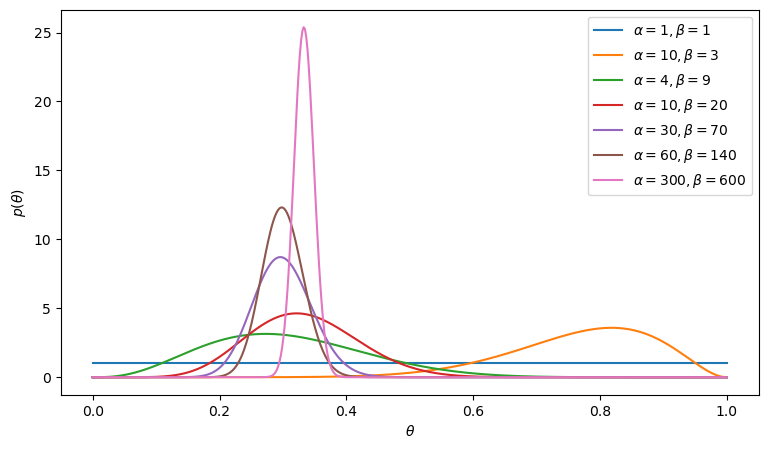

In [2]:
pi_grid = np.linspace(0, 1, num=500)

beta_params = [
    (1, 1),
    (10, 3),
    (4, 9),
    (10, 20),
    (30, 70),
    (60, 140),
    (300, 600)
]


fig, ax = plt.subplots(figsize=(9 ,5))

for params in beta_params:
    a, b = params
    beta_rv = st.beta(a=a, b=b)
    pdf = beta_rv.pdf(pi_grid)
    ax.plot(pi_grid, pdf, label=f"$\\alpha={a}, \\beta={b}$")

ax.legend()
ax.set(xlabel="$\\theta$", ylabel="$p(\\theta)$");

Si bien $\alpha$ y $\beta$ son cantidades continuas, es posible interpretarlas como (pseudo-) cantidades de éxitos y fracasos. Cuando $\alpha$ crece, mayor concentración de probabilidad alrededor de valores cercanos a 1. Cuando $\beta$ crece, mayor concentración de probabilidad en valores cercanos a 0.

Luego de una larga explicación de por qué proponemos el modelo que proponemos, podemos presentarlo resumidamente de la siguiente forma:

$$
\begin{aligned}
Y &\sim \text{Binomial}(N, \theta) \\
\theta &\sim \text{Beta}(\alpha, \beta)
\end{aligned}
$$

Este modelo es muy popular en estadística bayesiana y se conoce como modelo beta-binomial. A partir de este modelo bayesiano y los datos observados, simplemente la cantidad de éxitos $y=45$, queremos obtener el _posterior_.

Utilizando la regla de Bayes, es posible demostrar que la densidad _a posteriori_ $p(\theta \mid Y = y)$ es también la de una distribución beta con parámetros:

$$
\begin{aligned}
\alpha_\text{posterior} &= \alpha_\text{prior} + y \\
\beta_\text{posterior} &= \beta_\text{prior} + N - y
\end{aligned}
$$

En nuestro caso tenemos $y = 45$ en $N = 115$ turnos al bate. Si, por ejemplo, utilizamos un _prior_ uniforme, se tiene:

$$
\begin{aligned}
Y &\sim \text{Binomial}(115, \theta) \\
\theta &\sim \text{Beta}(1, 1) \\
\theta \mid y &\sim \text{Beta}(\underbrace{46}_{45 + 1}, \underbrace{71}_{115 - 45 + 1})
\end{aligned}
$$

Y podemos graficar la densidad a _priori_ junto con la densidad _a posteriori_.

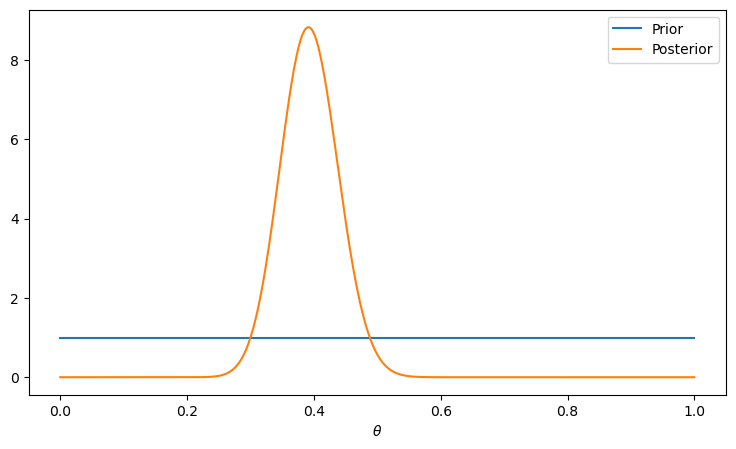

In [3]:
# Parámetros del prior
a_prior, b_prior = 1, 1

# Parámetros del posterior
a_posterior, b_posterior = 46, 71

# Grilla de valores para graficar la densidad
pi_grid = np.linspace(0, 1, num=500)

# Calcular densidad a priori 
pdf_prior = st.beta(a=a_prior, b=b_prior).pdf(pi_grid)

# Calcular densidad a posteriori
pdf_posterior = st.beta(a=a_posterior, b=b_posterior).pdf(pi_grid)

# Crear figura
fig, ax = plt.subplots(figsize=(9 ,5))

# Graficar densidades
ax.plot(pi_grid, pdf_prior, label="Prior")
ax.plot(pi_grid, pdf_posterior, label="Posterior")

# Etiquetas
ax.legend()
ax.set(xlabel="$\\theta$");

Es posible ver la "actualización" que se produjo en el conocimiento sobre $\theta$. _A priori_, pensábamos que todos los valores de $\theta$ eran igualmente probables. _A posteriori_, vemos que los valores de más probables $\theta$ son aquellos entre 0.3 y 0.5 (construyendo un intervalo a ojo).

Sin embargo, el gráfico que creamos por sí solo no da respuesta a nada... ¿Cómo resumimos la información en la distribución para responder a la pregunta inicial? Calculando cantidades de interés a partir de la densidad _a posteriori_ (i.e. valores esperados).

En particular, busquemos la media _a posteriori_ y un intervalo de credibilidad del 90%. Esto nos va a dar un rango donde se encuentra la mayor parte de la masa de probabilidad y por lo tanto los valores más plausibles de $\theta$.

Se cuenta con expresiones cerradas para algunas cantidades de interés (e.g. la media del _posterior_). Sin embargo, con el objetivo de obtener las respuestas a través de una interface consistente, usaremos los métodos implementados en las variables aleatorias de SciPy.


In [4]:
# Crear variable aleatoria 'beta'
rv_posterior = st.beta(a=a_posterior, b=b_posterior)
rv_posterior

Para obtener la media _a posteriori_ simplemente usamos el método `.mean()`

In [5]:
rv_posterior.mean() # es igual a alfa / (alfa + beta)

0.39316239316239315

Y para un intervalo de credibilidad el método `ppf` (_Percent Point Function_) que es la función inversa de la CDF (_Cumulative Density Function_).

In [6]:
rv_posterior.ppf((0.05, 0.95))

array([0.32021385, 0.4681968 ])

De esta manera, podemos dar respuesta a la pregunta inicial (¿cuál es la probabilidad de que Betts obtenga un _hit_?) de dos maneras distintas:

* Si tenemos que responder con un solo número, podemos decir que la probabilidad de _hit_ está alrededor del 40%
* Si se nos permite reportar un intervalo,  diremos que la probabilidad de _hit_ se encuentra entre el 32% y el 47%.

La segunda pregunta dice:

> ¿cuál es la probabilidad de que este jugador obtenga _hits_ en al menos el 40% de los casos al acumular 500 turnos al bate en la temporada?

Primero de todo, notemos que se nos está preguntando por la probabilidad de que la cantidad de _hits_ al cumular 500 turnos al bate sea al menos 200 (i.e. 0.4 * 500).

Para encontrar la probabilidad de que Mookie Betts obtenga _hits_ en al menos el 40% de los turnos al bate, tenemos que recurrir a la distribución **predictiva _a posteriori_**. Esto es así porque la pregunta refiere a **cantidad de _hits_** que es nuestra **variable observada** y no al parámetro $\theta$ que habla de la probabilidad de obtener un _hit_. 

La densidad de la distribución predictiva a _posteriori_ se define:

$$
p(\tilde{y}  \mid  y) = \int p(\tilde{y} \mid \theta) p(\theta \mid y) d\theta
$$

En nuestro modelo esta integral tiene solución analítica y el resultado es la función de masa de probabilidad de una [distribución beta-binomial](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_beta-binomial) de parámetros $\alpha$, $\beta$ y $N$. Los primeros dos son aquellos de la distribución beta y el último es la cantidad de ensayos.

En cuanto a la probabilidad de interés, la podemos escribir de la siguiente manera:

$$
P(\tilde{Y} \ge 200 \mid Y = y, N = 500)
$$

que equivale a la sumatoria

$$
P(\tilde{Y} \ge 200) = \sum_{\tilde{y} = 200}^{500} p(\tilde{y} \mid  y)
$$

Sin embargo, **ya hemos observado los primeros 115 turnos al bate** y para ellos sabemos cuántos éxitos se obtuvieron (45). Por lo tanto, tenemos que calcular la probabilidad de que Betts obtenga al menos $200 - 45 = 155$ _hits_ en los restantes $500 - 115 = 385$ turnos al bate.

$$
P(\tilde{Y} \ge 155 \mid Y = y, N = 385) = \sum_{\tilde{y} = 155}^{385} p(\tilde{y} \mid  y)
$$

La distribución beta-binomial también está implementada en SciPy y podemos visualizarla a través de su función de masa de probabilidad.


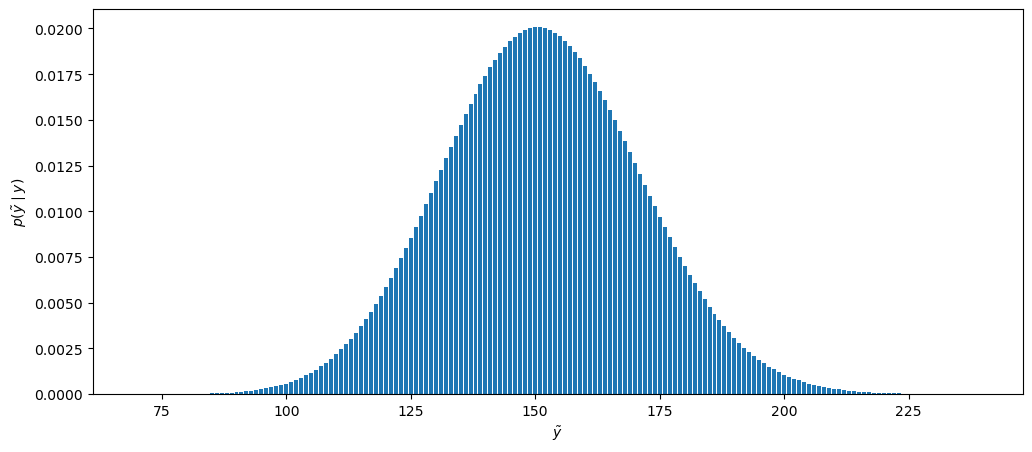

In [7]:
# Instanciar distribución beta-binomial
rv_posterior_predictive = st.betabinom(a=a_posterior, b=b_posterior, n=385)

# Crear grila de valores para y_tilde
y_tilde_grid = np.arange(70, 240)

# Obtener la probabilidad de cada valor en la grilla 
y_tilde_pmf = rv_posterior_predictive.pmf(y_tilde_grid)

# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

# Graficar función de masa de probabilidad
ax.bar(y_tilde_grid, y_tilde_pmf)

# Etiquetar
ax.set(xlabel="$\\tilde{y}$", ylabel="$p(\\tilde{y} \\mid y)$");

Podemos calcular la probabilidad de interés de varias maneras:

1. Sumando las alturas (probabilidades) de los bastones de los $\tilde{y}$ mayores o iguales a 155.
2. Computando $1 - P(\tilde{Y} < 155) = 1 - P(\tilde{Y} \le 154)$ a partir de la CDF.

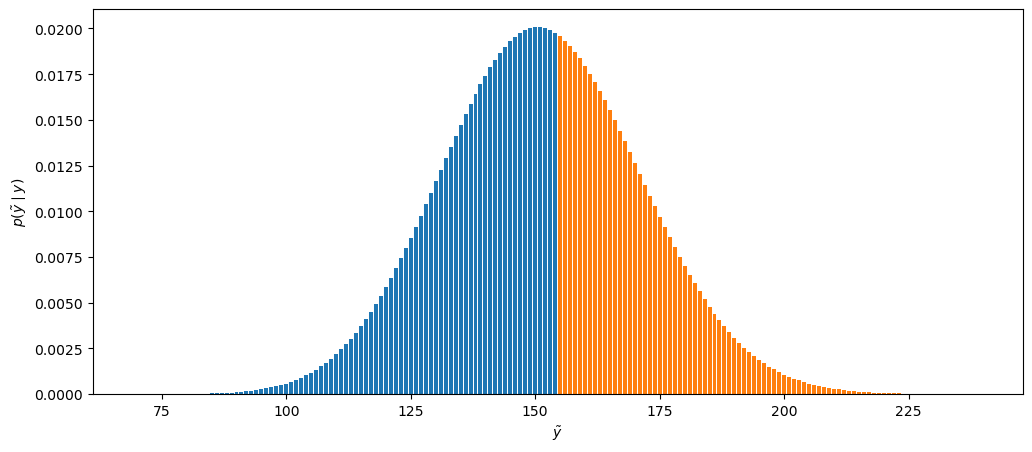

In [8]:
# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

color = ["C0" if y < 155 else "C1" for y in y_tilde_grid]

# Graficar función de masa de probabilidad
ax.bar(y_tilde_grid, y_tilde_pmf, color=color)

# Etiquetar
ax.set(xlabel="$\\tilde{y}$", ylabel="$p(\\tilde{y} \\mid y)$");

Con el primer enfoque, estaríamos sumando las alturas de los bastones en color naranja.

Con el segundo enfoque, estaríamos sustrayendo el total de las alturas en color azul a 1.

Ambos cálculos son equivalentes.

In [9]:
# P(Y >= 155) = 1 - P(Y < 155) = 1 - P(Y <= 154)
1 - rv_posterior_predictive.cdf(154)

0.4322182546856491

Finalmente, ¿cómo podríamos haber hecho las inferencias utilizando **Monte Carlo**?

Para las inferencias sobre $\theta$:

In [10]:
# Obtener muestras del posterior de pi
rvs_pi = rv_posterior.rvs(10_000)

# Calcular medias y cuantiles a partir de las muestras
print(np.mean(rvs_pi))
print(np.quantile(rvs_pi, (0.05, 0.95)))

0.3937640697125755
[0.32065149 0.46888817]


Y luego para las inferencias sobre futuras cantidades de _hits_:

In [11]:
# Con cada muestra de pi, obtener una muestra de la binomial con N = 385
rvs_y = st.binom(n=385, p=rvs_pi).rvs()

# Calcular la proporción de muestras que son mayores o iguales a 155.
(rvs_y >= 155).mean()

0.436

## ¿El fútbol siempre da revancha?

En la final del 2018 de la Copa del Mundo de la FIFA, Francia le ganó a Croacia por 4 a 2.

i. Si el mismo partido se jugara de nuevo (cosa que los franceses en aquella oportunidad no pidieron), ¿cuál es la probabilidad de que Francia ganara de nuevo?

ii. Considere que un equipo es mejor que otro si la cantidad promdio de goles que anota es mayor. ¿Qué probabilidad hay de que Francia fuera un mejor equipo que Croacia?

En el desarrollo de una respuesta para este problema vamos a ser más escuetos al justificar nuestras decisiones y supuestos. En el caso anterior fuimos tan explícitos y redundantes para que no se escape detalle que rozamos la pedantería. No hace falta.

**¿Cuál es un modelo observacional plausible?**

Hay dos cantidades observables: la cantidad de goles que hace Francia y la que hace Croacia. Ambas son conteos que, en teoría, no tienen una cota superior. Una distribución simple y popular que se puede utilizar en este caso es la Poisson. El supuesto subyacente es que los goles ocurren de manera independiente.

Como tenemos dos cantidades observables, podemos utilizar dos distribuciones Poisson independientes, una para cada una. Acá estamos suponiendo que la cantidad de goles que anota un equipo es independiente de la cantidad que anota el otro equipo.

Luego, tenemos:

$$
\begin{aligned}
Y_F & \sim \text{Poisson}(\lambda_F) \\
Y_C & \sim \text{Poisson}(\lambda_C) \\
\end{aligned}
$$

donde

* $Y_F$: cantidad de goles que anota Francia en un partido.
* $Y_C$: cantidad de goles que anota Croacia en un partido.
* $\lambda_F$: promedio de goles que anota Francia por partido.
* $\lambda_C$: promedio de goles que anota Croacia por partido.

**¿Cuáles son las cantidades conocidas y desconocidas de este modelo?**

Hay dos cantidades desconocidas, los parámetros $\lambda_F$ y $\lambda_C$. Las cantidades observadas son los goles convertidos en el partido: 4 para Francia y 2 para Croacia.

**¿Cuál es un modelo plausible para las cantidades desconocidas?**

$\lambda_F$ y $\lambda_C$ son cantidades continuas y positivas. Hay una gran variedad de distribuciones que tienen soporte en el intervalo $(0, \infty)$. 
Una distribución de probabilidad conveniente en este caso es la gamma. No tenemos motivos para pensar, _a priori_, que los parámetros de esta gamma son distintos para ambos equipos.

El modelo completo se escribe:


$$
\begin{aligned}
Y_F & \sim \text{Poisson}(\lambda_F) \\
Y_C & \sim \text{Poisson}(\lambda_C) \\
\lambda_F, \lambda_C &\sim \text{Gamma}(\alpha, \beta)
\end{aligned}
$$

$\lambda_F$ da una idea de la capacidad de Francia de hacer goles ($\lambda_C$ lo mismo, pero para Croacia).

¿Cuáles son valores sensibles para $\alpha$ y $\beta$?

Quisieramos una distribución gamma que concentre una gran parte de la probabilidad en un intervalo que creemos plausible. Por ejemplo, una gamma que concentre el 95% de probabilidad entre 1 y 4.

Hay varios enfoques distintos para obtener valores para los parámetros de la gamma:

* Graficar varias alternativas como hicimos para la beta y elegir una que refleje nuestros supuestos _a priori_. 
* Trabajar con la [función cuantil](https://statproofbook.github.io/P/gam-qf.html) de la gamma, aunque resulta complicado. 
* Usar [PreliZ](https://preliz.readthedocs.io/en/latest/), una para elucidación de _priors_. La usaremos cuando trabajemos con PyMC.
* Especificar valores deseados para la media y la varianza y resolver el sistema de ecuaciones.

Bajo el último de los enfoques mencionados, supongamos que se desea $\mu_\lambda = 1.5$ y $\sigma^2_\lambda = 1$. Luego resolvemos:

$$
\begin{cases}
\displaystyle \frac{\alpha}{\beta} = 1.5 \\
\displaystyle \frac{\alpha}{\beta^2} = 1
\end{cases}
$$

y se llega a que $\alpha = 1.5^2 = 2.25$ y $\beta = 1.5$.

Visualicemos la densidad del _prior_ que acabamos de encontrar.

**Nota**: Si utilizamos SciPy, debemos siempre revisar como parametriza a las distribuciones. En este caso, $\text{Gamma}(\alpha, \beta)$ es equivalente a `st.gamma(a=alpha, scale=1/beta)`.

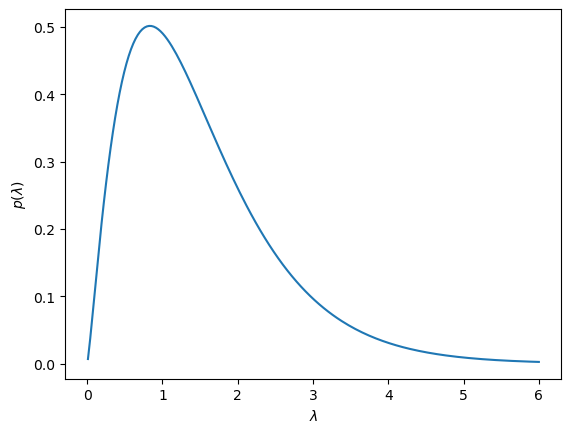

In [12]:
lambda_grid = np.linspace(0.01, 6, num=200)
rv_prior = st.gamma(a=2.25, scale=1/1.5)
pdf_prior = rv_prior.pdf(lambda_grid)

fig, ax = plt.subplots()
ax.plot(lambda_grid, pdf_prior)
ax.set(xlabel="$\\lambda$", ylabel="$p(\\lambda)$");

Y vemos que el 90% de la probabilidad está contenida en el siguiente intervalo:

In [13]:
rv_prior.ppf((0.05, 0.95))

array([0.30671422, 3.42939856])

Al igual que en el caso anterior, estamos trabajando con distribuciones conjugadas y la distribución _a posteriori_ para la cantidad promedio de goles que convierte cada equipo es una gamma de la siguiente forma:

$$
\lambda \mid y \sim \text{Poisson}(\alpha + \sum_{i=1}^{N}y_i, \beta + n)
$$

Luego, en nuestro caso:


$$
\begin{aligned}
Y_F & \sim \text{Poisson}(\lambda_F) \\
Y_C & \sim \text{Poisson}(\lambda_C) \\
\lambda_F, \lambda_C &\sim \text{Gamma}(\alpha, \beta) \\
\lambda_F \mid y_F &\sim \text{Gamma}(\alpha + y_F, \beta + 1) \equiv \text{Gamma}(6.25, 2.5) \\
\lambda_C \mid y_C &\sim \text{Gamma}(\alpha + y_C, \beta + 1) \equiv \text{Gamma}(4.25, 2.5)
\end{aligned}
$$


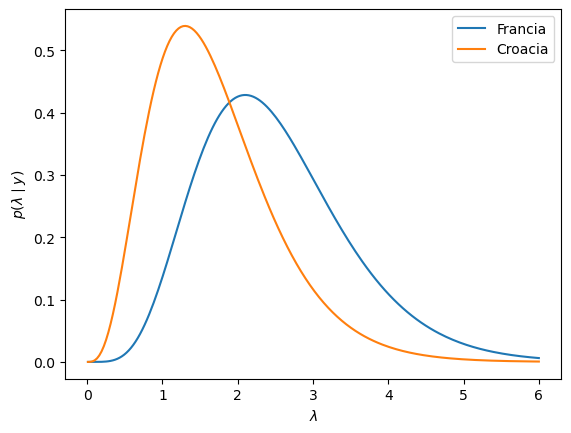

In [14]:
lambda_grid = np.linspace(0.01, 6, num=200)
rv_posterior_f = st.gamma(a=6.25, scale=1/2.5)
rv_posterior_c = st.gamma(a=4.25, scale=1/2.5)

pdf_posterior_f = rv_posterior_f.pdf(lambda_grid)
pdf_posterior_c = rv_posterior_c.pdf(lambda_grid)

fig, ax = plt.subplots()
ax.plot(lambda_grid, pdf_posterior_f, label="Francia")
ax.plot(lambda_grid, pdf_posterior_c, label="Croacia")
ax.legend()
ax.set(xlabel="$\\lambda$", ylabel="$p(\\lambda \\mid y)$");

A partir de estas distribuciones _a posteriori_ podemos responder la segunda pregunta planteada sobre qué probabilidad hay de que Francia sea mejor equipo que Croacia. Buscamos la siguiente probabilidad:

$$
P(\lambda_F > \lambda_C)
$$

Esta es una probabiliad que involucra dos variables aleatorias que siguen una distribución gamma y calcularla de manera analítica resulta [bastante complejo](https://stats.stackexchange.com/questions/48378/difference-of-gamma-random-variables). 

En casos como este, resulta conveniente utilizar métodos de Monte Carlo. Lo único que necesitamos es obtener muestras de la distribución conjunta de $(\lambda_F, \lambda_C)$ y calcula la proporción de casos donde $\lambda_F > \lambda_C$. Como $\lambda_F$ y $\lambda_C$ son independientes, podemos muestrear de las gammas univariadas.

In [15]:
# Obtenemos 2000 muestras del posterior
lambda_f_rvs = rv_posterior_f.rvs(2_000)
lambda_c_rvs = rv_posterior_c.rvs(2_000)

Podemos visualizar las muestras del _posterior_ en el plano y colorearlas según $\lambda_F$ sea mayor a $\lambda_C$ o no.

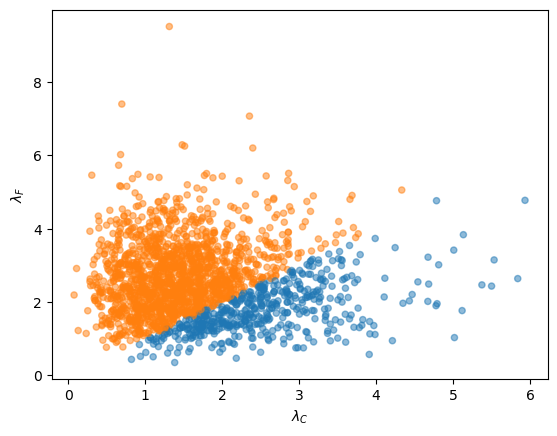

In [16]:
fig, ax = plt.subplots()

color = ["C1" if f > c else "C0" for f, c in zip(lambda_f_rvs, lambda_c_rvs)]
ax.scatter(lambda_c_rvs, lambda_f_rvs, s=20, alpha=0.5, color=color)
ax.set(xlabel="$\\lambda_C$", ylabel="$\\lambda_F$");

Y la estimación de la probabilidad de que Francia sea mejor que Croacia (i.e. que haga más goles en promedio) es:

In [17]:
(lambda_f_rvs > lambda_c_rvs).mean()

0.7565

Por otro lado, para responder cuál es la probabilidad de que Francia gane de nuevo si el partido se vuelve a jugar, necesitamos trabajar con las distribuciones predictivas _a posteriori_.

$$
P(\tilde{Y}_F > \tilde{Y}_C \mid y_F, y_C)
$$

En este caso, la distribuciones predictivas están dadas por la [distribución Gamma-Poisson](https://timothy-barry.github.io/posts/2020-06-16-gamma-poisson-nb/) (también conocida cono binomial negativa). Pero nuevamente, la probabilidad de interés involucra dos variables aleatorias y por lo tanto haremos uso de la simulación para computarla.

Para obtener muestras de la distribución predictiva _a posteriori_, primero obtenemos muestras del posterior de $\lambda$ (ya lo hicimos antes) y con cada uno de esos $\lambda$ muestreados simulamos un valor de una distribución Poisson.

In [18]:
y_f_rvs = st.poisson(lambda_f_rvs).rvs()
y_c_rvs = st.poisson(lambda_c_rvs).rvs()

Podemos visualizar las muestras en un gráfico similar al que obtuvimos para las muestras del _posterior_.

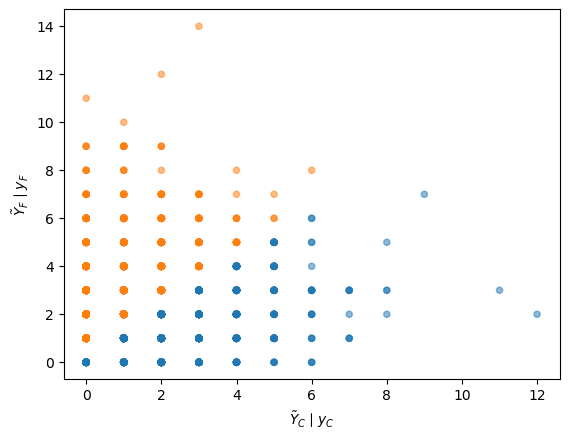

In [19]:
fig, ax = plt.subplots()

color = ["C1" if f > c else "C0" for f, c in zip(y_f_rvs, y_c_rvs)]
ax.scatter(y_c_rvs, y_f_rvs, s=20, alpha=0.5, color=color)
ax.set(xlabel="$\\tilde{Y}_C \\mid y_C$", ylabel="$\\tilde{Y}_F \\mid y_F$");

Los valores que obtenemos son enteros mayores o iguales a cero y por lo tanto hay mucho solapamiento. Este no es el gráfico más adecuado porque no permite distinguir claramente cuáles son los valores con mayor probabilidad. Si bien se puede apreciar algo a partir del solapamiento de puntos, no es lo ideal.

Podemos armar una tabla de contingencia y visualizar los conteos a través de un _heatmap_.

In [20]:
crosstab = st.contingency.crosstab(y_f_rvs, y_c_rvs)
print(crosstab.elements)
print(crosstab.count)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12]))
[[ 45  76  63  29  13   4   3   0   0   0   0   0]
 [108 142  99  64  32  15   3   3   0   0   0   0]
 [107 129  83  69  33   8   4   1   1   0   0   1]
 [ 96  98  77  40  23   9   6   4   2   0   1   0]
 [ 60  72  44  25  24   9   1   0   0   0   0   0]
 [ 32  36  34  18   9   9   2   0   1   0   0   0]
 [ 19  23  15   8   4   2   2   0   0   0   0   0]
 [  8   8   8   6   1   1   0   0   0   1   0   0]
 [  4   3   1   0   1   0   1   0   0   0   0   0]
 [  3   7   3   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0]]


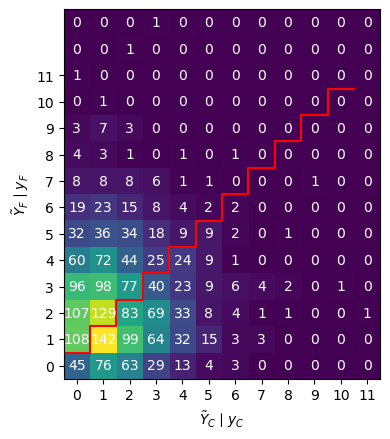

In [21]:
fig, ax = plt.subplots()

ax.imshow(crosstab.count);

for i, x in enumerate(crosstab.elements[0]) :
    for j, y in enumerate(crosstab.elements[1]):
        ax.text(j, i, crosstab.count[i, j],ha="center", va="center", color="w")

ax.set(xlabel="$\\tilde{Y}_C \\mid y_C$", ylabel="$\\tilde{Y}_F \\mid y_F$")
ax.invert_yaxis()

ax.set(xticks=np.arange(12), yticks=np.arange(12))
ax.step(np.arange(12) - 0.5, np.arange(12) - 0.5, color="red");

Estamos interesados en la proporción de muestras por sobre la línea roja.

In [22]:
(y_f_rvs > y_c_rvs).mean()

0.5375

Si bien Francia sigue siendo quien tiene mayor chance de ganar, este resultado es menor que la probabilidad de superioridad.

Y tiene sentido, porque estamos menos seguros del resultado de un solo partido que del promedio de goles de un equipo. Incluso si Francia fuera el mejor equipo, podría perder el partido.

**Nota** Solo consideramos los casos donde Francia hace más goles que Croacia. Es posible tener en cuenta a los empates y proponer que, por ejemplo, Francia gana 50% de ellos.

# Ejercicios

1. Resolver el problema "La suerte de Betts" utilizando un _prior_ no uniforme para $\theta$ que incorpore el conocimiento volcado en la descripción del problema. Justifique su elección del _prior_.
2. A que respuesta se llega cuando se ignora que se observaron los primeros 115 turnos al bate? ¿Por qué?

# Comentarios

**1. $p(Y = y)$ _versus_ $p(y)$**

A veces escribimos $p(\theta \mid Y = y)$ y otras veces $p(\theta \mid y)$, omitiendo la variable aleatoria $Y$. El segundo caso es una versión abreviada de la primera. Ambos indican la densidad (o función de masa de probabilidad) de $\theta$ dado un valor fijo de $Y$ que es $y$.

Usamos mayúsculas para variables aleatorias $Y$ y minúsculas para realizaciones de la variable aleatoria (valores observados) $y$.

**2. ¿El fútbol siempre da revancha?**

El ejercicio ¿El fútbol siempre da revancha? está tomado del [Capítulo 8 de Think Bayes](https://allendowney.github.io/ThinkBayes2/chap08.html) de Allen Downey.